### Data Labling

In this notebook we are going to use [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) algorithim for clustering on the features that we are having so that we can give our dataset correct labels.

**What is clustering?**

> Grouping elements, things that belongs to the same category in the same group. Clustering involves finding groups
where all elements in the group are similar, but objects in different groups are not.

So after clustering our features all the features that belongs to the same category will be clustered to their own cluster. And later on we are going to use these clusters to create labels on our new dataset. We are intrested in labling our data using `2` labels which are outcome of the `NSFAS` funding. These labels are:

1. `0`
2. `1`

> Note that the original dataset was having `2` classes. We are going to make these labels categoricals from `0` and `1` to
1. `ineligible`
2. `eligible`

-- respectively.


In the following code cell we are going to import all the packages that we are going to use in this notebook.


In [1]:
import numpy as np
import pandas as pd
import os
import random
import time

from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

print("pandas:", pd.__version__)
print("numpy:", np.__version__)

pandas: 1.5.3
numpy: 1.24.3


We are then going to set the `SEED` for random operations that we are going to have for reproducivity.

In [2]:
SEED = 23
random.seed(SEED)
np.random.seed(SEED)

Next we are going to define the path to where our `dataset_combined.xlsx` file is located. This file contain the data of mislabeled features. And we are also going to define the `OUTPUT_PATH` wich is the path to the file with correct labeled dataset. We are going to save the correctly labeled dataset as a `csv` file with a name `dataset_combined.csv`

In [3]:
BASE_DIR = './'
DATA_PATH = os.path.join(BASE_DIR, 'data/', 'dataset_combined.xlsx')
OUTPUT_PATH = os.path.join(BASE_DIR, 'data/', 'dataset_combined.csv')

assert os.path.exists(DATA_PATH), f"The path '{DATA_PATH}' does not exists."

Next we are going to read our `dataset_combined.xlsx` file into a dataframe and check the last `5` rows that are in this dataset.

In [29]:
dataframe = pd.read_excel(DATA_PATH)
dataframe.tail().reset_index(drop=True)

,Name,Education Qualification,Gender,Community,Religion,Exservice-men,Disability,Sports,Annual-Percentage,Income,India,Outcome
0,National Overseas Scholarship Scheme 2021-22,Doctrate,Female,Minority,Muslim,No,No,No,60-70,Above 6L,Out,1
1,National Overseas Scholarship Scheme 2021-22,Doctrate,Female,Minority,Chirstian,No,No,Yes,60-70,Above 6L,Out,1
2,National Overseas Scholarship Scheme 2021-22,Doctrate,Female,Minority,Chirstian,No,No,No,60-70,Above 6L,Out,1
3,National Overseas Scholarship Scheme 2021-22,Doctrate,Female,Minority,Others,No,No,Yes,60-70,Above 6L,Out,1
4,National Overseas Scholarship Scheme 2021-22,Doctrate,Female,Minority,Others,No,No,No,60-70,Above 6L,Out,1


We can check our unique labels using that we are having in the following code cell.

In [30]:
labels = dataframe['Outcome'].unique()
labels

array([1, 0], dtype=int64)

From our clustering task we are going to learn all the features which are:

1. `Name`	
2. `Education Qualification`	
3. `Gender`
5. `Religion`	
6. `Exservice-men`
7. `Disability` 
8. `Sports`
9. `Annual-Percentage`
10. `Income`	
12. `India`	

These are the features that we think that they have a greater impact on the `Outcome` of funcing. We are going to drop the `Outcome` column as we are not intrested in it.


In [31]:
features_df = dataframe.drop(["Outcome"], axis=1)
features_df.head()

,Name,Education Qualification,Gender,Community,Religion,Exservice-men,Disability,Sports,Annual-Percentage,Income,India
0,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Hindu,Yes,Yes,Yes,90-100,Upto 1.5L,In
1,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Hindu,Yes,Yes,No,90-100,Upto 1.5L,In
2,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Muslim,Yes,Yes,Yes,90-100,Upto 1.5L,In
3,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Muslim,Yes,Yes,No,90-100,Upto 1.5L,In
4,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Chirstian,Yes,Yes,Yes,90-100,Upto 1.5L,In


So we are going to create a pipeline that will work on tranforming our data in the way that we want. We are going to use something called [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) from `sklearn`. We are going to encode each column surperately. Here are the transformations that we are going to make for our featues.

1. Education Qualification	- [`OrdinalEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) -> [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
2. Gender	- [`OrdinalEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) -> [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
3. Community	- [`OrdinalEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) -> [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
4. Religion	- [`OrdinalEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) -> [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
5. Exservice-men	- [`OrdinalEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) -> [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
6. Disability	- [`OrdinalEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) -> [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
7. Sports	- [`OrdinalEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) -> [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
8. Annual-Percentage	- [`OrdinalEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) -> [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
9. Income	- [`OrdinalEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) -> [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
10. India	- [`OrdinalEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) -> [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
9. Name	- [`OrdinalEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) -> [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)


In [32]:
feature_columns = features_df.columns
feature_columns

Index(['Name', 'Education Qualification', 'Gender', 'Community', 'Religion',
       'Exservice-men', 'Disability', 'Sports', 'Annual-Percentage', 'Income',
       'India'],
      dtype='object')

In [33]:
encode_scale_pipeline = Pipeline([
  ('ordinal_encoder', OrdinalEncoder()),
  ('standard_scaler', StandardScaler())
])
ct = ColumnTransformer([
        ("instution_process", encode_scale_pipeline, feature_columns),
])
features_transformed = ct.fit_transform(features_df)

We can check the first 2 `rows` of the transformed features in the following code cell as follows:

In [34]:
features_transformed[:2]

array([[-0.17407766,  1.22474487,  1.        , -1.34164079, -0.4472136 ,
         1.        ,  1.        ,  1.        ,  1.34164079,  1.34164079,
        -1.        ],
       [-0.17407766,  1.22474487,  1.        , -1.34164079, -0.4472136 ,
         1.        ,  1.        , -1.        ,  1.34164079,  1.34164079,
        -1.        ]])

Next we are going to create a clusting model using the [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) algorithm. We are setting the `n_clusters` to `2` because we want to cluster our features into `2` classes which are:

1. `0`
2. `1`


In [35]:
N_CLUSTERS = 2
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=SEED, n_init=10)
kmeans.fit(features_transformed)

KMeans(n_clusters=2, n_init=10, random_state=23)

We can check the labels that we got from the algorithm using the `labels_` propety as follows:

In [36]:
kmeans.labels_

array([1, 1, 1, ..., 0, 0, 0])

We can check the unique labels using the `set()` method as follows:

In [37]:
set(kmeans.labels_)

{0, 1}

We can check the `score` of our algorithm using the `score` method and pass the features as follows:

In [38]:
kmeans.score(features_transformed)

-2457599.999999791

Now it's time to analyse our predictions dataframe rows before relabling them using the clustering algorithm. First we are going to check the our dataframe head by calling the `head` method. But we are going to attech some `prediction` column on this dataframe so that we can analyse how the model is labling our dataset together with our eyes we are going to map `{0, 1}` to our target labels `{0, 1}`

In [39]:
dataframe['prediction'] = kmeans.predict(features_transformed)
dataframe.head(20)

,Name,Education Qualification,Gender,Community,Religion,Exservice-men,Disability,Sports,Annual-Percentage,Income,India,Outcome,prediction
0,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Hindu,Yes,Yes,Yes,90-100,Upto 1.5L,In,1,1
1,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Hindu,Yes,Yes,No,90-100,Upto 1.5L,In,1,1
2,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Muslim,Yes,Yes,Yes,90-100,Upto 1.5L,In,1,1
3,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Muslim,Yes,Yes,No,90-100,Upto 1.5L,In,1,1
4,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Chirstian,Yes,Yes,Yes,90-100,Upto 1.5L,In,1,1
5,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Chirstian,Yes,Yes,No,90-100,Upto 1.5L,In,1,1
6,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Others,Yes,Yes,Yes,90-100,Upto 1.5L,In,1,1
7,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Others,Yes,Yes,No,90-100,Upto 1.5L,In,1,1
8,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Hindu,Yes,Yes,Yes,90-100,Upto 1.5L,Out,0,1
9,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Hindu,Yes,Yes,No,90-100,Upto 1.5L,Out,0,1


Next we are going to create a `labels_dict` which maps a number to a categorical label as follows:

In [40]:
labels_dict = {
    0: 'ineligible',
    1: 'eligible'
}

> Note that the we used our eyes together with the use of the `clustering` model to come up with the categorical labels. Next we are going to label our dataset by updating the `Outcome` column, and droping the `prediction` label as follows:

In [41]:
def set_label(row):
    l = row.prediction
    row['Outcome'] = labels_dict[l]
    return row

dataframe = dataframe.apply(set_label, axis=1)
dataframe.drop(columns=['prediction'], inplace=True)

We can check the first `20` rows of the labeled dataset using the `head()` method as follows:

In [42]:
dataframe.head(20)

,Name,Education Qualification,Gender,Community,Religion,Exservice-men,Disability,Sports,Annual-Percentage,Income,India,Outcome
0,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Hindu,Yes,Yes,Yes,90-100,Upto 1.5L,In,eligible
1,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Hindu,Yes,Yes,No,90-100,Upto 1.5L,In,eligible
2,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Muslim,Yes,Yes,Yes,90-100,Upto 1.5L,In,eligible
3,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Muslim,Yes,Yes,No,90-100,Upto 1.5L,In,eligible
4,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Chirstian,Yes,Yes,Yes,90-100,Upto 1.5L,In,eligible
5,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Chirstian,Yes,Yes,No,90-100,Upto 1.5L,In,eligible
6,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Others,Yes,Yes,Yes,90-100,Upto 1.5L,In,eligible
7,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Others,Yes,Yes,No,90-100,Upto 1.5L,In,eligible
8,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Hindu,Yes,Yes,Yes,90-100,Upto 1.5L,Out,eligible
9,INSPIRE Scholarship 2022-23 ? Scholarship for ...,Undergraduate,Male,General,Hindu,Yes,Yes,No,90-100,Upto 1.5L,Out,eligible


Now that we have relabeled our dataset next we are going to save our dataset as a `csv` file as follows:

In [43]:
dataframe.to_csv(OUTPUT_PATH, index=False)
print('Saved!!')

Saved!!


We can visualize the first `100` examples to their respective clusters or `classes` as follows:

In [44]:
n = 150
y = [i.mean() for i in features_transformed[:n]]
x = np.arange(n)
c = kmeans.labels_[:n]

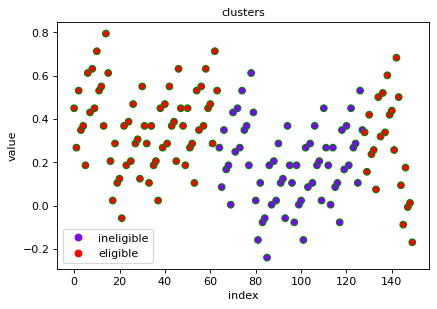

In [45]:
plt.figure(figsize=(6, 4), dpi=80)
scatter = plt.scatter(x, y, c=c, cmap='rainbow', edgecolor="g")
plt.title("clusters", color="k", fontsize=10)
plt.xlabel("index", fontsize=10)
plt.ylabel("value", fontsize=10)
plt.legend(handles=scatter.legend_elements()[0], labels=[labels_dict[i] for i in set(kmeans.labels_)])
plt.show()

### Refs

1. [scikit-learn.org](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
2. [github.com/CrispenGari](https://github.com/CrispenGari/python-sklearn/blob/main/unsupervised_learning/unsupervised_learning.ipynb)